# **PV PRODUCTION PREDICTIONS**

In this section of the project, we will focus on predicting the photovoltaic (PV) output of the solar panels installed at the faculty using meteorological data. To achieve this, it is essential to gather all available information about the solar panels as well as relevant meteorological data.

Our plan is to train our model using the comprehensive production data available from September 2023 to April 28, 2024. By analyzing these patterns, the model will learn and be able to accurately predict solar panel production for the upcoming days.

In the following notebook, you will find the entire process we used to generate predictions for the PV production over the next five days, which are displayed on our website. Each section provides detailed explanations of the steps involved.



# Prepare Our Data


First and foremost, we will embark on the data preprocessing phase to ensure that our data is in a suitable format. This step is foundational in every project as it serves as the starting point. Correctly preprocessing the data is essential as it lays the groundwork for subsequent analyses and modeling.

In [ ]:
#ALL THE NECESSARY IMPORTS
import pandas as pd
import numpy as np
import json
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, kendalltau, pointbiserialr
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from datetime import datetime
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import joblib

In [ ]:
#FV PRODUCTION FOR MONTHS 9,10,11,12
filepath = "/content/Producció FV 2023 Q.csv"
df_fv = pd.read_csv("fv.csv", delimiter=';', encoding='latin-1')
df_fv['Fecha'] = pd.to_datetime(df_fv['Fecha'], format='%d/%m/%Y')
grouped = df_fv.groupby(df_fv['Fecha'].dt.month)
monthly_dataframes = {}
for month, data in grouped:
    monthly_dataframes[month] = data

for month, data in monthly_dataframes.items():
    print(f"Data for each Month {month}:")
    print(data)
    print()

production_data_by_month = {}

for month, data in monthly_dataframes.items():

    production_data = data['Producció (kWh)'].tolist()

    production_data_by_month[month] = production_data

full_list = []
for month, production_data in production_data_by_month.items():
  np_list = np.array(production_data)
  flipped_np = np.flip(np_list)
  flipped_list = flipped_np.tolist()
  full_list.extend(flipped_list)

print(full_list)


FileNotFoundError: [Errno 2] No such file or directory: 'fv.csv'

Now, we are going to incorporate the new FV production data.

In [ ]:
#FV PRODUCTION FOR MONTHS 1,2,3,4

filepath = "/content/fv2.csv"
df_fv = pd.read_csv(filepath, delimiter=';', encoding='latin-1')


print("Column names in the DataFrame before dropping columns:")
print(df_fv.columns)

# we drop the specified columns
columns_to_drop = ['Punto frontera vertido (kWh)', 'Nombre', 'EcolÃ³gico (%)', 'HSP (kWh/m2)']
df_fv = df_fv.drop(columns=columns_to_drop)


print("Column names in the DataFrame after dropping columns:")
print(df_fv.columns)

# we convert 'Fecha' column to datetime
df_fv['Fecha'] = pd.to_datetime(df_fv['Fecha'], format='mixed')

# and then we group by month
grouped = df_fv.groupby(df_fv['Fecha'].dt.month)
monthly_dataframes = {month: data for month, data in grouped}

# print data for each month
for month, data in monthly_dataframes.items():
    print(f"Data for Month {month}:")
    print(data)
    print()

# Step 6: Extract production data by month
production_column = 'Producción (kWh)'  # Ensure the column name matches exactly
production_data_by_month = {}

for month, data in monthly_dataframes.items():
    if production_column in data.columns:
        production_data = data[production_column].tolist()
        production_data_by_month[month] = production_data
    else:
        print(f"Column '{production_column}' not found in the data for month {month}")

# Print production data by month
print("Production data by month:")
for month, production_data in production_data_by_month.items():
    print(f"Month {month}: {production_data}")

Column names in the DataFrame before dropping columns:
Index(['Nombre', 'Fecha', 'Punto frontera vertido (kWh)',
       'Punto frontera entrada (kWh)', 'ProducciÃ³n (kWh)', 'Consumo (kWh)',
       'EcolÃ³gico (%)', 'HSP (kWh/m2)', 'Performance ratio (%)'],
      dtype='object')
Column names in the DataFrame after dropping columns:
Index(['Fecha', 'Punto frontera entrada (kWh)', 'ProducciÃ³n (kWh)',
       'Consumo (kWh)', 'Performance ratio (%)'],
      dtype='object')
Data for Month 1:
         Fecha Punto frontera entrada (kWh) ProducciÃ³n (kWh) Consumo (kWh)  \
15  2024-01-05                     14446,43            1786,3      16232,73   
45  2024-01-04                      12534,6           1731,81      14266,41   
76  2024-01-03                            0            270,12        270,12   
105 2024-01-02                      12814,4            823,29      13637,69   
106 2024-01-31                      12678,2             904,2       13582,4   
107 2024-01-30                    

In [ ]:
def parse_dates(date):
    return pd.to_datetime(date, dayfirst=True, errors='coerce')

# we try reading the CSV file with a semicolon delimiter
try:
    df = pd.read_csv('fv2.csv', delimiter=';')
except UnicodeDecodeError:
    # if there's an encoding error, try reading with a different encoding
    df = pd.read_csv('fv2.csv', delimiter=';', encoding='latin1')


print("Column names in the CSV file:")
print(df.columns)

# we remove any leading or trailing spaces from the column names
df.columns = df.columns.str.strip()
print("Cleaned column names in the CSV file:")
print(df.columns)

# parsing of the "Fecha" column as dates
df['Fecha'] = df['Fecha'].apply(parse_dates)

# up to "28-04-2024"
cutoff_date = pd.to_datetime('28-04-2024', dayfirst=True)
filtered_df = df[df['Fecha'] <= cutoff_date]

# we reverse the order of the rows
reversed_df = filtered_df.iloc[::-1]

# and extract the columns named "Fecha" and "Producción (kWh)"
try:
    extracted_columns = reversed_df[['Fecha', 'Producción (kWh)']]
    extracted_columns.to_csv('produccio_def2024.csv', index=False)
    print(extracted_columns)
except KeyError as e:
    print(f"Error: {e}")
    print("The specified columns were not found in the CSV file.")

Column names in the CSV file:
Index(['Nombre', 'Fecha', 'Punto frontera vertido (kWh)',
       'Punto frontera entrada (kWh)', 'Producción (kWh)', 'Consumo (kWh)',
       'Ecológico (%)', 'HSP (kWh/m2)', 'Performance ratio (%)'],
      dtype='object')
Cleaned column names in the CSV file:
Index(['Nombre', 'Fecha', 'Punto frontera vertido (kWh)',
       'Punto frontera entrada (kWh)', 'Producción (kWh)', 'Consumo (kWh)',
       'Ecológico (%)', 'HSP (kWh/m2)', 'Performance ratio (%)'],
      dtype='object')
         Fecha Producción (kWh)
136 2024-01-01           381,56
135 2024-01-02           321,84
134 2024-01-03           179,07
133 2024-01-04              303
132 2024-01-05           138,89
..         ...              ...
22  2024-04-24          2083,94
21  2024-04-25           822,58
20  2024-04-26          1821,52
19  2024-04-27           697,45
18  2024-04-28           420,83

[119 rows x 2 columns]


In [ ]:
#PV PRODUCTION OF 2024 (until 28th april)

filepath = "/content/produccio_def2024.csv"
df_fv = pd.read_csv("produccio_def2024.csv", delimiter=',', encoding='latin-1')
df_fv["Fecha"] = pd.to_datetime(df_fv["Fecha"], format='%Y-%m-%d')
grouped = df_fv.groupby(df_fv["Fecha"].dt.month)
monthly_dataframes = {}
for month, data in grouped:
    monthly_dataframes[month] = data

for month, data in monthly_dataframes.items():
    print(f"Data for each Month {month}:")
    print(data)
    print()

production_data_by_month = {}

for month, data in monthly_dataframes.items():

    production_data = data["ProducciÃ³n (kWh)"].tolist()

    production_data_by_month[month] = production_data

#we reverse the lists and create another one with all the data in order from the first of september to the 31st of december

full_2024 = []
for month, production_data in production_data_by_month.items():
  np_list = np.array(production_data)
  full_2024.extend(np_list)

print(full_2024)

Data for each Month 1:
        Fecha ProducciÃ³n (kWh)
0  2024-01-01            381,56
1  2024-01-02            321,84
2  2024-01-03            179,07
3  2024-01-04               303
4  2024-01-05            138,89
5  2024-01-06            614,38
6  2024-01-07            631,99
7  2024-01-08            624,09
8  2024-01-09            477,06
9  2024-01-10            147,55
10 2024-01-11            589,21
11 2024-01-12            752,73
12 2024-01-13            758,55
13 2024-01-14            559,66
14 2024-01-15            366,18
15 2024-01-16             338,7
16 2024-01-17            404,47
17 2024-01-18            751,45
18 2024-01-19            102,55
19 2024-01-20            797,11
20 2024-01-21            799,11
21 2024-01-22            792,32
22 2024-01-23            700,61
23 2024-01-24            805,22
24 2024-01-25            831,68
25 2024-01-26             775,2
26 2024-01-27            789,42
27 2024-01-28            652,82
28 2024-01-29             204,9
29 2024-01-30    

In [ ]:
#WE CREATE A NEW LIST WITH ALL THE ORDERED DATA WE HAVE FOR PV PRODUCTION

defn_list = full_list + full_2024

print(defn_list)
print(len(defn_list))

NameError: name 'full_list' is not defined

# Plots

In the data preprocessing stage, it's crucial to generate plots for visualizing the data. This helps us understand its structure, relationships, progression, and other key aspects.

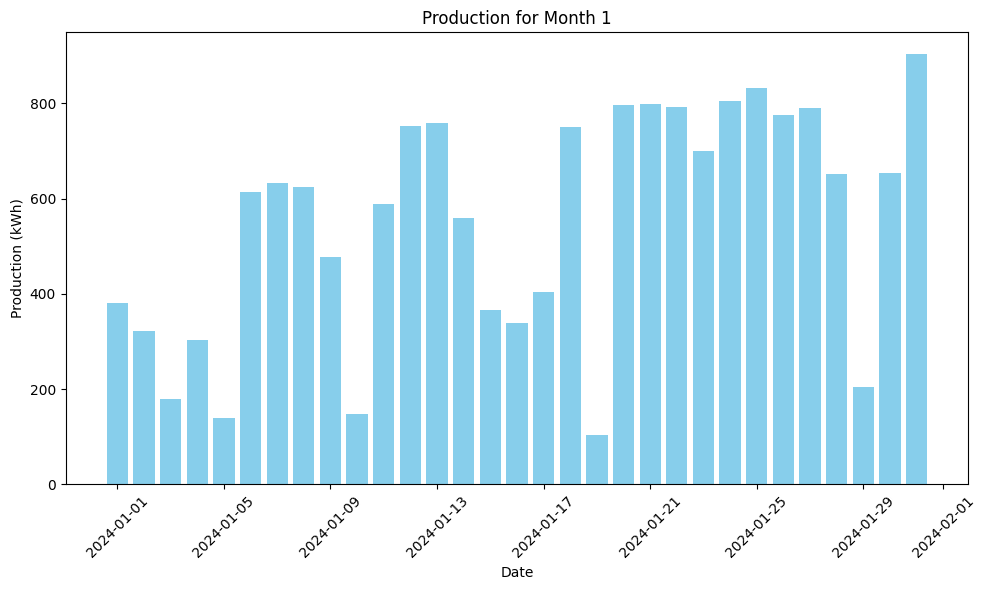

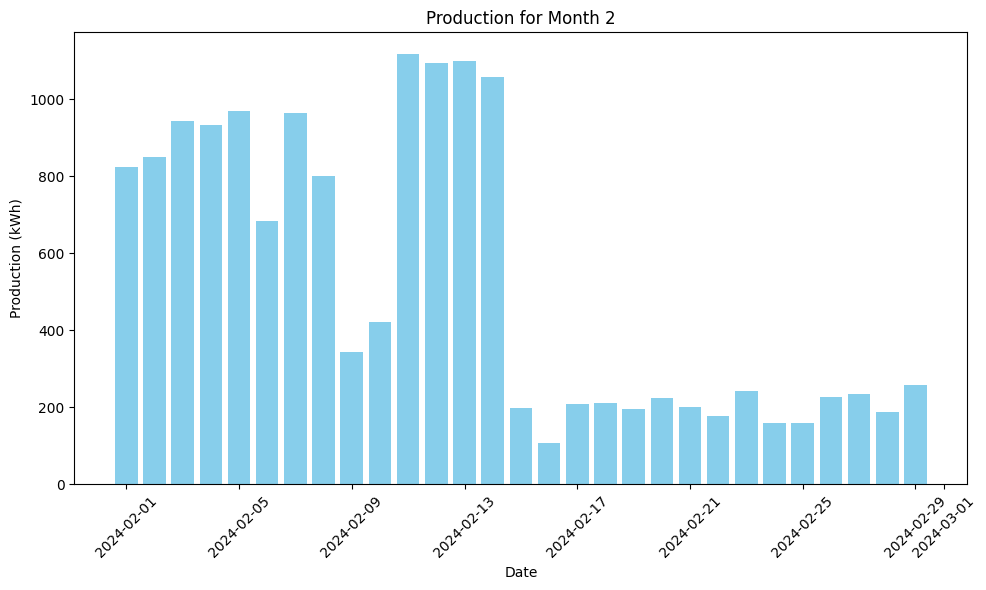

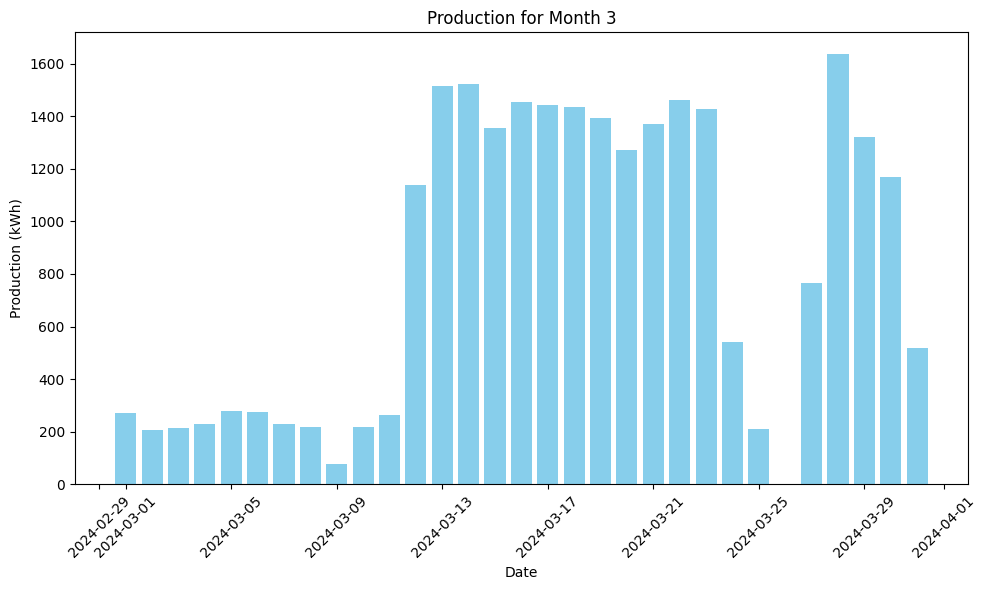

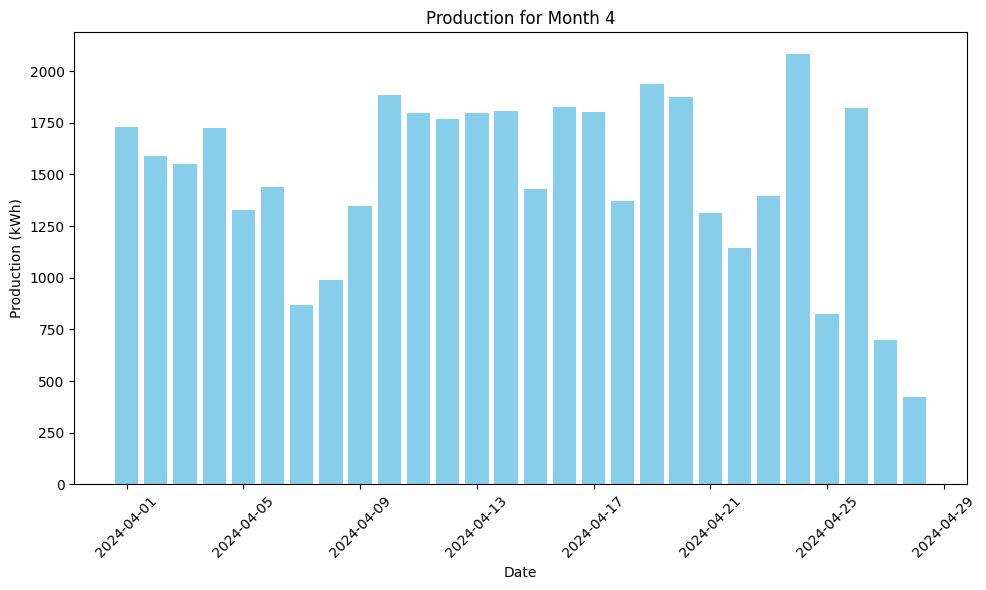

In [ ]:
#VISUALIZATION OF MONTHLY PV PRODUCTION FROM JANUARY TO APRIL
for month, data in monthly_dataframes.items():
    dates = [entry['Fecha'] for entry in data.to_dict('records')]
    production = [float(entry['ProducciÃ³n (kWh)'].replace(',', '.')) for entry in data.to_dict('records')]

    plt.figure(figsize=(10, 6))
    plt.bar(dates, production, color='skyblue')
    plt.title(f"Production for Month {month}")
    plt.xlabel("Date")
    plt.ylabel("Production (kWh)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
#
production_stats = {
    'Month': [],
    'Total Production (kWh)': [],
    'Average Daily Production (kWh)': [],
    'Max Daily Production (kWh)': [],
    'Min Daily Production (kWh)': [],
}

for month, data in monthly_dataframes.items():
    # we verify the column name and handle potential errors as the name is written in a strange way
    try:
        production_values = [float(entry.replace(',', '.')) for entry in data['ProducciÃ³n (kWh)']]  # we check for typos in the column name
    except KeyError:
        print(f"Warning: 'ProducciÃ³n (kWh)' column not found for month {month}. Skipping.")
        continue  # we skip to the next month if the column is missing

    total_production = np.sum(production_values)
    average_daily_production = total_production / len(data)
    max_daily_production = np.max(production_values)
    min_daily_production = np.min(production_values)

    production_stats['Month'].append(month)
    production_stats['Total Production (kWh)'].append(total_production)
    production_stats['Average Daily Production (kWh)'].append(average_daily_production)
    production_stats['Max Daily Production (kWh)'].append(max_daily_production)
    production_stats['Min Daily Production (kWh)'].append(min_daily_production)

production_stats_df = pd.DataFrame(production_stats)
print(production_stats_df)

   Month  Total Production (kWh)  Average Daily Production (kWh)  \
0      1                17149.52                      553.210323   
1      2                15102.68                      520.782069   
2      3                25429.23                      820.297742   
3      4                41558.22                     1484.222143   

   Max Daily Production (kWh)  Min Daily Production (kWh)  
0                      904.20                      102.55  
1                     1117.97                      107.27  
2                     1636.93                        1.06  
3                     2083.94                      420.83  


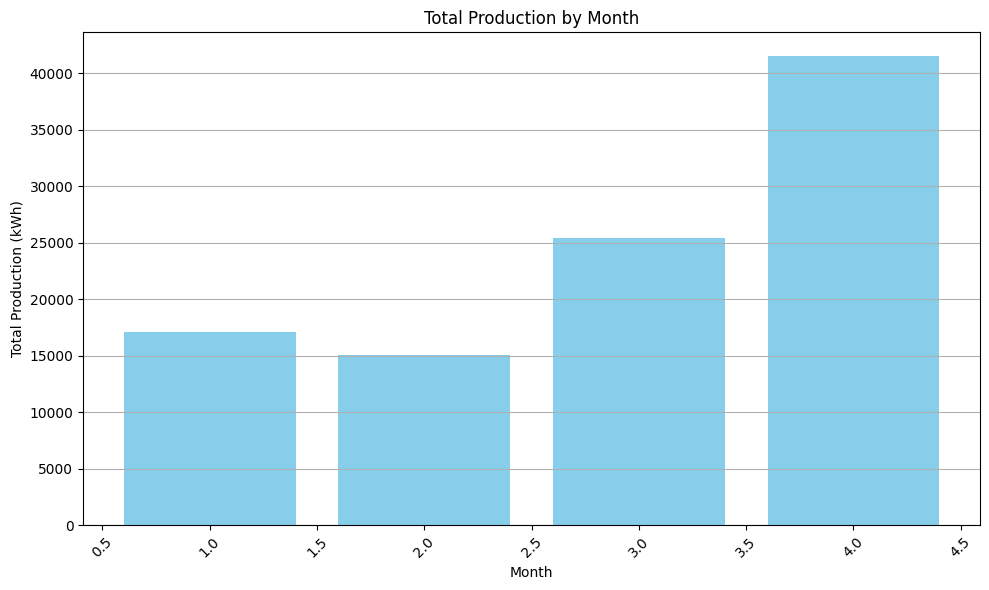

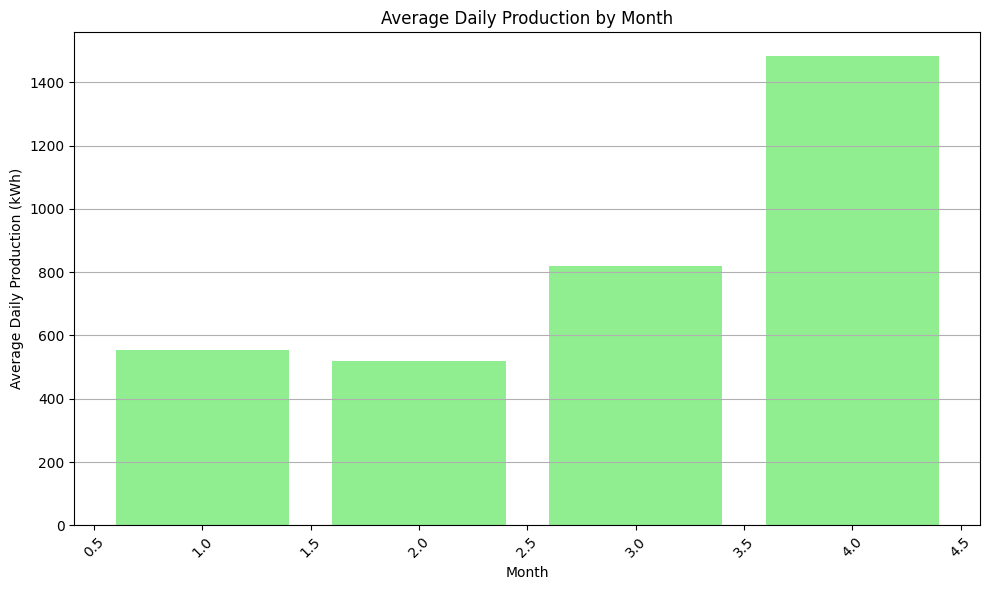

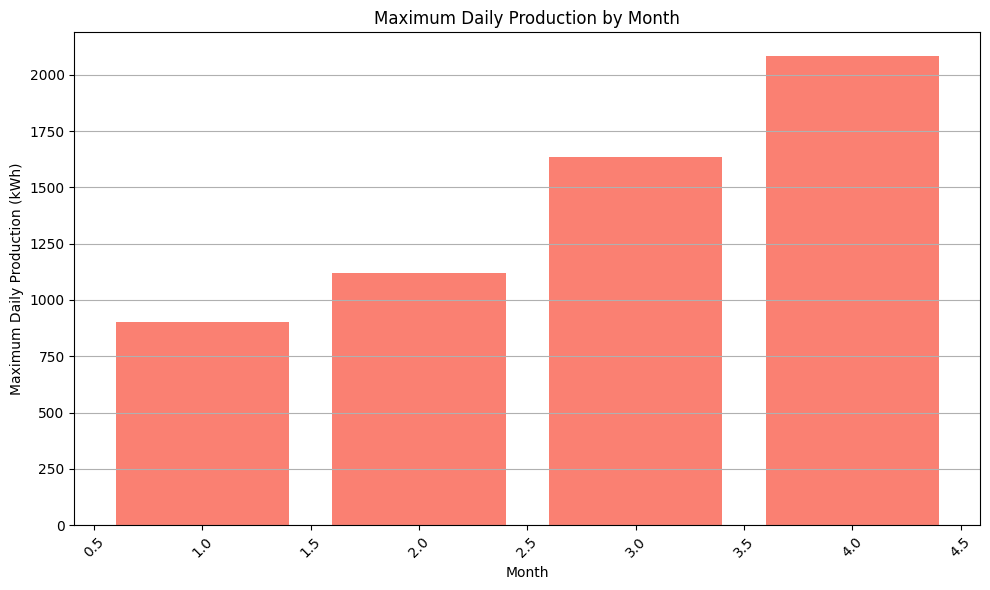

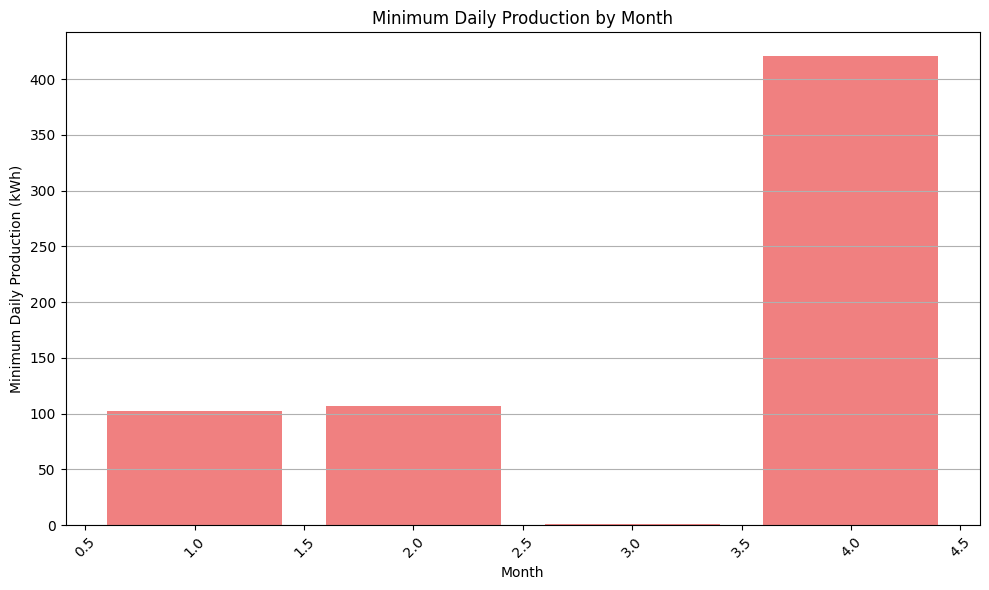

In [ ]:
#PLOTS
plt.figure(figsize=(10,6))
plt.bar(production_stats_df['Month'], production_stats_df['Total Production (kWh)'], color='skyblue')
plt.xlabel('Month')
plt.ylabel('Total Production (kWh)')
plt.title('Total Production by Month')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# average Daily Production by Month
plt.figure(figsize=(10, 6))
plt.bar(production_stats_df['Month'], production_stats_df['Average Daily Production (kWh)'], color='lightgreen')
plt.xlabel('Month')
plt.ylabel('Average Daily Production (kWh)')
plt.title('Average Daily Production by Month')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#maximum Daily Production by Month
plt.figure(figsize=(10, 6))
plt.bar(production_stats_df['Month'], production_stats_df['Max Daily Production (kWh)'], color='salmon')
plt.xlabel('Month')
plt.ylabel('Maximum Daily Production (kWh)')
plt.title('Maximum Daily Production by Month')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#minimum Daily Production by Month
plt.figure(figsize=(10, 6))
plt.bar(production_stats_df['Month'], production_stats_df['Min Daily Production (kWh)'], color='lightcoral')
plt.xlabel('Month')
plt.ylabel('Minimum Daily Production (kWh)')
plt.title('Minimum Daily Production by Month')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


# Aemet Fabra Data

In the file datosFabra.txt, we have a list containing a dictionary for each day. The keys are:

- fecha: Date
- indicativo: Climatological Indicator
- nombre: Station Location
- provincia: Province
- altitud: Altitude
- tmed: Daily Average Temperature
- prec: Precipitation (measured in mm; 1 mm equals 1 liter per square meter)
- tmin: Minimum Temperature
- horatmin: Time of Minimum Temperature (unit: hour:min)
- dir: Maximum Gust Direction (unit: tens of degrees)
- velmedia: Average Wind Speed (unit: m/s)
- racha: Maximum Wind Gust (unit: m/s)
- horaracha: Time of Maximum Wind Gust
- sol: Insolation. The amount of energy in the form of radiation that reaches a specific location. To measure insolation levels, a threshold is established: the sunlight must exceed 120 watts per square meter of surface. It is measured in hours (i.e., the hours during which this threshold is exceeded).
- presMax: Maximum Pressure at the station's reference level (hPa)
- horaPresMax: Time of Maximum Pressure
- presMin: Minimum Pressure (hPa)
- horaPresMin: Time of Minimum Pressure
- hrMedia: Daily Average Relative Humidity (measured in percentage (%). The maximum humidity percentage is reached when the air is saturated, meaning it cannot hold any more water at that temperature).

We will create a condensed list containing only the measurements we consider relevant, due to the limited availability of photovoltaic production data.

In [ ]:
#METEO
import json
file_path = "/content/datosFabra.txt"
with open('datosFabra.txt', 'r') as file:
    file_contents = file.read()
    dictionary_data = json.loads(file_contents)

with open ("datosFabra_reducido.txt", "w") as output_file:

    output_list = []
    for i, data in enumerate(dictionary_data):
        output_dict = {
            "fecha": data.get("fecha", ""),
            "tmed": data.get('tmed', ""),
            "prec": data.get('prec', ""),
            "tmin": data.get('tmin', ""),
            "tmax": data.get('tmax', ""),
            "sol": data.get('sol', ""),
        }
        output_list.append(output_dict)

    json.dump(output_list, output_file)

file_path = "/content/datosFabra_reducido.txt"
with open('datosFabra_reducido.txt', 'r') as file:
    file_contents = file.read()

list_ = json.loads(file_contents)

#Try
print(list_[2])

import re

lista_4 = []
for item in list_:
    if "fecha" in item:
        fecha = item["fecha"]
        if re.match(r"2023-(09|10|11|12)-\d{2}|2024-(01|02|03|04)-\d{2}", fecha):
            lista_4.append(item)

print(lista_4)


#We will choose different variables individually an store them in a list in order to be able to do the correlation between each of them and the phootovoltaic production

# we initialize empty lists for each key
fecha_list = []
tmed_list = []
prec_list = []
tmin_list = []
tmax_list = []
sol_list = []


# extraction of values for each key into separate lists
for item in lista_4:
    fecha_list.append(item.get('fecha', ''))
    tmed_list.append(item.get('tmed', ''))
    prec_list.append(item.get('prec', ''))
    tmin_list.append(item.get('tmin', ''))
    tmax_list.append(item.get('tmax', ''))
    sol_list.append(item.get('sol', ''))

print("fecha_list:", fecha_list)
print("tmed_list:", tmed_list)
print("prec_list:", prec_list)
print("tmin_list:", tmin_list)
print("tmax_list:", tmax_list)
print("sol_list:", sol_list)

{'fecha': '2019-10-04', 'tmed': '20,4', 'prec': '0,0', 'tmin': '16,2', 'tmax': '24,7', 'sol': '10,0'}
[{'fecha': '2023-09-01', 'tmed': '24,0', 'prec': '0,0', 'tmin': '19,6', 'tmax': '28,4', 'sol': ''}, {'fecha': '2023-09-02', 'tmed': '22,0', 'prec': 'Ip', 'tmin': '20,1', 'tmax': '23,9', 'sol': ''}, {'fecha': '2023-09-03', 'tmed': '23,5', 'prec': '0,0', 'tmin': '19,3', 'tmax': '27,7', 'sol': ''}, {'fecha': '2023-09-04', 'tmed': '25,8', 'prec': '0,0', 'tmin': '21,5', 'tmax': '30,0', 'sol': ''}, {'fecha': '2023-09-05', 'tmed': '25,3', 'prec': '0,0', 'tmin': '20,8', 'tmax': '29,8', 'sol': ''}, {'fecha': '2023-09-06', 'tmed': '24,4', 'prec': '0,0', 'tmin': '19,4', 'tmax': '29,4', 'sol': ''}, {'fecha': '2023-09-07', 'tmed': '23,0', 'prec': '0,0', 'tmin': '17,7', 'tmax': '28,4', 'sol': ''}, {'fecha': '2023-09-08', 'tmed': '24,1', 'prec': '0,0', 'tmin': '19,2', 'tmax': '29,0', 'sol': ''}, {'fecha': '2023-09-09', 'tmed': '23,4', 'prec': '0,0', 'tmin': '18,2', 'tmax': '28,7', 'sol': ''}, {'fecha

# Correlation Temperature and PV production

To ensure the robustness of our methodology, we will evaluate the correlation between temperature and PV production. This analysis will help us gain a deeper understanding of our data.

In [ ]:
defn_list_float = [float(num_str.replace(",", ".")) for num_str in defn_list]

#tmed_list
tmed_list_float = [float(num_str.replace(",", ".")) for num_str in tmed_list]
pearson_corr_tmed, _ = pearsonr(defn_list_float, tmed_list_float)
print("Pearson correlation coefficient of tmed and PV is", pearson_corr_tmed)

#tmin_list
tmin_list_float = [float(num_str.replace(",", ".")) for num_str in tmin_list]
pearson_corr_tmin, _ = pearsonr(defn_list_float, tmin_list_float)
print("Pearson correlation coefficient of tmin and PV is", pearson_corr_tmin)

#tmax list
tmax_list_float = [float(num_str.replace(",", ".")) for num_str in tmax_list]
pearson_corr_tmax, _ = pearsonr(defn_list_float, tmax_list_float)
print("Pearson correlation coefficient of tmax and PV is", pearson_corr_tmax)




Pearson correlation coefficient of tmed and PV is 0.4404951206335189
Pearson correlation coefficient of tmin and PV is 0.3633402405372172
Pearson correlation coefficient of tmax and PV is 0.49331066617618863


The Pearson correlation coefficients between temperature variables and PV production reveal moderate positive relationships. The correlation between the mean temperature (tmed) and PV production is 0.44, indicating a moderate positive association. Similarly, the correlation between the minimum temperature (tmin) and PV production is 0.36, which is slightly weaker but still positive. The maximum temperature (tmax) shows the strongest correlation with PV production at 0.49. These results suggest that as temperature increases, PV production tends to increase as well, with maximum temperature having the most significant impact among the three temperature measures.

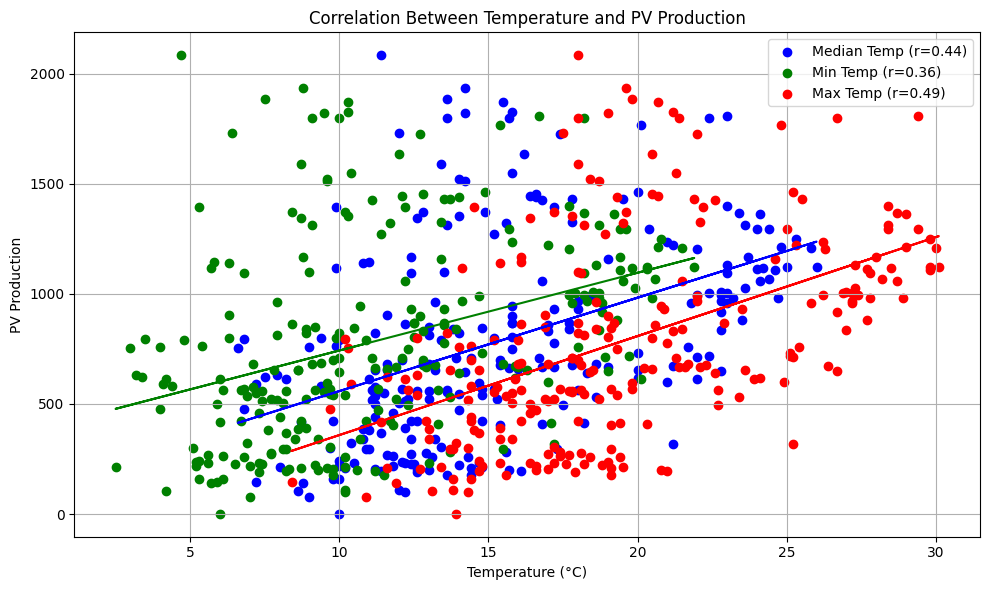

In [ ]:
#PLOTTING THE CORRELATION OF TEMPERATURE AND PV PRODUCTION

import numpy as np

# Function to add a regression line
def add_regression_line(x, y, color):
    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m*np.array(x) + b, color=color)

# Plotting the data
plt.figure(figsize=(10, 6))

# Scatter plot for Median Temperature vs PV Production
plt.scatter(tmed_list_float, defn_list_float, color='blue', label=f'Median Temp (r={pearson_corr_tmed:.2f})')
add_regression_line(tmed_list_float, defn_list_float, 'blue')

# Scatter plot for Minimum Temperature vs PV Production
plt.scatter(tmin_list_float, defn_list_float, color='green', label=f'Min Temp (r={pearson_corr_tmin:.2f})')
add_regression_line(tmin_list_float, defn_list_float, 'green')

# Scatter plot for Maximum Temperature vs PV Production
plt.scatter(tmax_list_float, defn_list_float, color='red', label=f'Max Temp (r={pearson_corr_tmax:.2f})')
add_regression_line(tmax_list_float, defn_list_float, 'red')

# Adding titles and labels
plt.title('Correlation Between Temperature and PV Production')
plt.xlabel('Temperature (°C)')
plt.ylabel('PV Production')
plt.legend()

# Showing the plot
plt.grid(True)
plt.tight_layout()
plt.show()


# Predicting values for SOL variable

Since we don't have complete information about the SOL (insolation) variable across the entire dataset, we have decided to fill in the gaps by making predictions based on the available data. This approach allows us to expand our dataset and improve our analysis.

In [ ]:
# DATA PROCESS OF THE FILE AND EXTRACTION OF FEATURES AND TARGET VALUES

with open("datosFabra_reducido.txt", "r") as file:
    file_contents = file.read()

data = json.loads(file_contents)

# we modify 'prec' values in the dataset
for entry in data:
    if entry['prec'] == "Ip":
        entry['prec'] = "0.0"

# In order to work with correct values we have to convert ',' to '.' and convert string values to float
for entry in data:
    for key, value in entry.items():
        if key != 'fecha' and ',' in value:
            entry[key] = float(value.replace(",", "."))

# also it is necessary to convert date strings to datetime objects
for item in data:
    item['fecha'] = datetime.datetime.strptime(item['fecha'], '%Y-%m-%d')

# extraction of features and target values
features = []
target = []
for item in data:
    if item['sol'] != '':
        # in order to handle empty strings we replace them with 0.0
        hrMedia_value = float(item['hrMedia']) if item['hrMedia'] != '' else 0.0
        features.append([float(item['tmed']), float(item['prec']),
                         float(item['tmin']), float(item['tmax']),
                         hrMedia_value])
        target.append(float(item['sol']))

In [ ]:
#PREDICTING MISSING VALUES FOR SOL WITH AN MLP

# first we convert the lists to arrays and then we standarize the features
features = np.array(features)
target = np.array(target)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# split of the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# mlp parameters and initiliaziation
model = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', random_state=42)
model.fit(X_train, y_train)


# prediction missing values
missing_indices = [i for i, item in enumerate(data) if item['sol'] == '']
for i in missing_indices:
    tmed_value = float(data[i]['tmed'])
    prec_value = float(data[i]['prec'])
    tmin_value = float(data[i]['tmin'])
    tmax_value = float(data[i]['tmax'])

    # we have to handle empty string in 'hrMedia' field
    hrMedia_value = float(data[i]['hrMedia']) if data[i]['hrMedia'] != '' else 0.0

    input_data = np.array([[tmed_value, prec_value, tmin_value, tmax_value, hrMedia_value]])
    input_data_scaled = scaler.transform(input_data)
    predicted_sol = model.predict(input_data_scaled)
    data[i]['sol'] = str(predicted_sol[0]).replace('.', ',')

# in order to see the results we print the data with interpolated values
for item in data:
    print(item)


{'fecha': datetime.datetime(2019, 10, 2, 0, 0), 'tmed': 20.6, 'prec': 0.0, 'tmin': 16.2, 'horatmin': '04:14', 'tmax': 25.1, 'sol': 8.8, 'hrMedia': '71'}
{'fecha': datetime.datetime(2019, 10, 3, 0, 0), 'tmed': 18.9, 'prec': 0.0, 'tmin': 13.4, 'horatmin': '06:28', 'tmax': 24.4, 'sol': 8.8, 'hrMedia': '63'}
{'fecha': datetime.datetime(2019, 10, 4, 0, 0), 'tmed': 20.4, 'prec': 0.0, 'tmin': 16.2, 'horatmin': 'Varias', 'tmax': 24.7, 'sol': 10.0, 'hrMedia': '73'}
{'fecha': datetime.datetime(2019, 10, 5, 0, 0), 'tmed': 18.2, 'prec': '0.0', 'tmin': 16.4, 'horatmin': 'Varias', 'tmax': 20.0, 'sol': 0.6, 'hrMedia': '88'}
{'fecha': datetime.datetime(2019, 10, 6, 0, 0), 'tmed': 18.4, 'prec': 0.0, 'tmin': 16.6, 'horatmin': '06:06', 'tmax': 20.2, 'sol': 0.2, 'hrMedia': '90'}
{'fecha': datetime.datetime(2019, 10, 7, 0, 0), 'tmed': 19.4, 'prec': 0.0, 'tmin': 13.9, 'horatmin': '06:33', 'tmax': 24.9, 'sol': 9.0, 'hrMedia': '53'}
{'fecha': datetime.datetime(2019, 10, 8, 0, 0), 'tmed': 20.4, 'prec': '0.0', 

We can also try different models and compare them in order to choose the one with better results. In the following code, we are going to train two different models: XGBoost and KNN.

In [ ]:

#KNN
knn_model = KNeighborsRegressor()
knn_model.fit(X_train, y_train)

#XGB
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

#missing values using KNN
knn_predictions = knn_model.predict(X_test)

#missing values using XGBoost
xgb_predictions = xgb_model.predict(X_test)

# evlauation of the models
knn_mae = mean_absolute_error(y_test, knn_predictions)
knn_mse = mean_squared_error(y_test, knn_predictions)
knn_r2 = r2_score(y_test, knn_predictions)

xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)

mlp_mae = mean_absolute_error(y_test, model.predict(X_test))
mlp_mse = mean_squared_error(y_test, model.predict(X_test))
mlp_r2 = r2_score(y_test, model.predict(X_test))

# prints of the evaluation results
print("KNN Metrics:")
print("Mean Absolute Error:", knn_mae)
print("Mean Squared Error:", knn_mse)
print("R^2 Score:", knn_r2)
print()

print("XGBoost Metrics:")
print("Mean Absolute Error:", xgb_mae)
print("Mean Squared Error:", xgb_mse)
print("R^2 Score:", xgb_r2)
print()

print("MLPRegressor Metrics:")
print("Mean Absolute Error:", mlp_mae)
print("Mean Squared Error:", mlp_mse)
print("R^2 Score:", mlp_r2)


KNN Metrics:
Mean Absolute Error: 2.119475409836065
Mean Squared Error: 7.588815737704916
R^2 Score: 0.4662792272683356

XGBoost Metrics:
Mean Absolute Error: 2.021827521624624
Mean Squared Error: 6.935488640515507
R^2 Score: 0.5122276670790408

MLPRegressor Metrics:
Mean Absolute Error: 1.7740707943392036
Mean Squared Error: 5.543344531980083
R^2 Score: 0.6101370451747159


The evaluation metrics demonstrate that the MLPRegressor outperforms both the KNN and XGBoost models across all measured dimensions. Its lower Mean Absolute Error and Mean Squared Error, combined with a higher R^2 score, illustrate that it provides more accurate and reliable predictions. Note that the R^2 score represents the proportion of the variance in the dependent variable that is predictable from the independent variables. An R^2 score closer to 1 indicates a better fit.

In [ ]:
#THIS CODE IS HANDLING THE SOL VALUES CHANGING THEM FROM , TO . AND CREATING A NEW FILE WITH THE INTERPOLATED VALUES FROM THE MLP

# iteration over the data and replace commas with periods in the 'sol' variable
for item in data:
    if isinstance(item['sol'], str) and ',' in item['sol']:
        item['sol'] = item['sol'].replace(',', '.')

# new text file
output_file = "DatosFabra_reducido_sol.txt"

with open(output_file, "w") as file:
    for item in data:
        # we convert 'fecha' to datetime object if it's not already
        if isinstance(item['fecha'], str):
            item['fecha'] = datetime.strptime(item['fecha'], '%Y-%m-%d')
        # and also convert datetime object to string
        item['fecha'] = item['fecha'].strftime('%Y-%m-%d')
        json.dump(item, file)
        file.write('\n')

print("New file 'DatosFabra_reducido_sol.txt' created with updated 'sol' values.")


New file 'DatosFabra_reducido_sol.txt' created with updated 'sol' values.


In [ ]:
with open("DatosFabra_reducido_sol.txt") as file:
  file_contents = file.read()
  print(file_contents)


{"fecha": "2019-10-02", "tmed": 20.6, "prec": 0.0, "tmin": 16.2, "horatmin": "04:14", "tmax": 25.1, "sol": 8.8, "hrMedia": "71"}
{"fecha": "2019-10-03", "tmed": 18.9, "prec": 0.0, "tmin": 13.4, "horatmin": "06:28", "tmax": 24.4, "sol": 8.8, "hrMedia": "63"}
{"fecha": "2019-10-04", "tmed": 20.4, "prec": 0.0, "tmin": 16.2, "horatmin": "Varias", "tmax": 24.7, "sol": 10.0, "hrMedia": "73"}
{"fecha": "2019-10-05", "tmed": 18.2, "prec": "0.0", "tmin": 16.4, "horatmin": "Varias", "tmax": 20.0, "sol": 0.6, "hrMedia": "88"}
{"fecha": "2019-10-06", "tmed": 18.4, "prec": 0.0, "tmin": 16.6, "horatmin": "06:06", "tmax": 20.2, "sol": 0.2, "hrMedia": "90"}
{"fecha": "2019-10-07", "tmed": 19.4, "prec": 0.0, "tmin": 13.9, "horatmin": "06:33", "tmax": 24.9, "sol": 9.0, "hrMedia": "53"}
{"fecha": "2019-10-08", "tmed": 20.4, "prec": "0.0", "tmin": 16.6, "horatmin": "01:31", "tmax": 24.1, "sol": 9.7, "hrMedia": "72"}
{"fecha": "2019-10-09", "tmed": 18.1, "prec": 2.0, "tmin": 14.8, "horatmin": "21:40", "tma

In [ ]:
# filter data for months 9, 10, 11, and 12 of 2023, and months 1, 2, 3 of 2024, and till the day 28 of month 4 of 2024
filtered_data = []
for entry in data:
    fecha = entry["fecha"]
    year, month, day = fecha.split("-")
    month = int(month)
    day = int(day)
    if (year == "2023" and month in [9, 10, 11, 12]) or (year == "2024" and month in [1, 2, 3]):
        filtered_data.append(entry)
    elif year == "2024" and month == 4 and day <= 28:
        filtered_data.append(entry)


In [ ]:
print(filtered_data)

[{'fecha': '2023-09-01', 'tmed': 24.0, 'prec': 0.0, 'tmin': 19.6, 'horatmin': '', 'tmax': 28.4, 'sol': '11.33337391482263', 'hrMedia': ''}, {'fecha': '2023-09-02', 'tmed': 22.0, 'prec': '0.0', 'tmin': 20.1, 'horatmin': '', 'tmax': 23.9, 'sol': '8.32414924104895', 'hrMedia': ''}, {'fecha': '2023-09-03', 'tmed': 23.5, 'prec': 0.0, 'tmin': 19.3, 'horatmin': '', 'tmax': 27.7, 'sol': '10.984905441065267', 'hrMedia': ''}, {'fecha': '2023-09-04', 'tmed': 25.8, 'prec': 0.0, 'tmin': 21.5, 'horatmin': '', 'tmax': 30.0, 'sol': '11.720052919319825', 'hrMedia': ''}, {'fecha': '2023-09-05', 'tmed': 25.3, 'prec': 0.0, 'tmin': 20.8, 'horatmin': '', 'tmax': 29.8, 'sol': '11.826896766978711', 'hrMedia': ''}, {'fecha': '2023-09-06', 'tmed': 24.4, 'prec': 0.0, 'tmin': 19.4, 'horatmin': '', 'tmax': 29.4, 'sol': '12.067194130918738', 'hrMedia': ''}, {'fecha': '2023-09-07', 'tmed': 23.0, 'prec': 0.0, 'tmin': 17.7, 'horatmin': '', 'tmax': 28.4, 'sol': '12.039662254008322', 'hrMedia': ''}, {'fecha': '2023-09-0

We had a list (defn_list) with the ordered fotovoltaic production (from september 2023 to april (28th) of 2024). We now want to add this to the filtered data csv

In [ ]:
print(defn_list)

['1295,15', '613,25', '882,32', '1208,12', '1249,62', '1296,99', '1398,08', '1364,09', '1365,63', '1312,98', '1057,85', '980,74', '1109,8', '1116,34', '318,69', '1094,59', '1069,29', '1210,78', '711,35', '669,46', '1008,19', '1295,76', '1157,02', '1235,88', '1223,3', '1202,5', '1166,88', '1130,24', '1121,25', '1120,2', '1112,5', '837,6', '965,92', '1025,03', '718,37', '960,11', '917,88', '979,91', '1002,04', '995', '1004,23', '992,83', '957,11', '757,73', '412,2', '294,56', '618,18', '651,02', '533,22', '859,02', '898,64', '667,22', '652,86', '932,67', '669,55', '598,62', '841,27', '866,11', '681,42', '493,79', '706,97', '658,18', '257,27', '862,14', '596,76', '865,55', '844,36', '838,97', '812,28', '392,29', '707,3', '473,72', '639,03', '730,43', '674,3', '282,9', '410,8', '676,09', '710,84', '674,78', '663,01', '645,17', '683,35', '681,13', '655,2', '521,46', '386,2', '338,94', '546,38', '99,92', '562,86', '228,3', '614,19', '583,48', '503,57', '418,44', '574,87', '499,73', '441,28',

In [ ]:
for i, data in enumerate(filtered_data):
    data['fv'] = defn_list[i]

print(filtered_data)

[{'fecha': '2023-09-01', 'tmed': 24.0, 'prec': 0.0, 'tmin': 19.6, 'horatmin': '', 'tmax': 28.4, 'sol': '11.33337391482263', 'hrMedia': '', 'fv': '1295,15'}, {'fecha': '2023-09-02', 'tmed': 22.0, 'prec': '0.0', 'tmin': 20.1, 'horatmin': '', 'tmax': 23.9, 'sol': '8.32414924104895', 'hrMedia': '', 'fv': '613,25'}, {'fecha': '2023-09-03', 'tmed': 23.5, 'prec': 0.0, 'tmin': 19.3, 'horatmin': '', 'tmax': 27.7, 'sol': '10.984905441065267', 'hrMedia': '', 'fv': '882,32'}, {'fecha': '2023-09-04', 'tmed': 25.8, 'prec': 0.0, 'tmin': 21.5, 'horatmin': '', 'tmax': 30.0, 'sol': '11.720052919319825', 'hrMedia': '', 'fv': '1208,12'}, {'fecha': '2023-09-05', 'tmed': 25.3, 'prec': 0.0, 'tmin': 20.8, 'horatmin': '', 'tmax': 29.8, 'sol': '11.826896766978711', 'hrMedia': '', 'fv': '1249,62'}, {'fecha': '2023-09-06', 'tmed': 24.4, 'prec': 0.0, 'tmin': 19.4, 'horatmin': '', 'tmax': 29.4, 'sol': '12.067194130918738', 'hrMedia': '', 'fv': '1296,99'}, {'fecha': '2023-09-07', 'tmed': 23.0, 'prec': 0.0, 'tmin': 1

In [ ]:
# filtered data to a new JSON file
output_file = "dataDefn.json"
with open(output_file, "w") as file:
    json.dump(filtered_data, file, indent=4)

print("Filtered data for months 9,10,11,12 of 2023 and 1,2,3,4 (till 28th) of 2024.")

Filtered data for months 9,10,11,12 of 2023 and 1,2,3,4 (till 28th) of 2024.


In [ ]:
print(json.dumps(filtered_data, indent=4))


[
    {
        "fecha": "2023-09-01",
        "tmed": 24.0,
        "prec": 0.0,
        "tmin": 19.6,
        "horatmin": "",
        "tmax": 28.4,
        "sol": "11.33337391482263",
        "hrMedia": "",
        "fv": "1295,15"
    },
    {
        "fecha": "2023-09-02",
        "tmed": 22.0,
        "prec": "0.0",
        "tmin": 20.1,
        "horatmin": "",
        "tmax": 23.9,
        "sol": "8.32414924104895",
        "hrMedia": "",
        "fv": "613,25"
    },
    {
        "fecha": "2023-09-03",
        "tmed": 23.5,
        "prec": 0.0,
        "tmin": 19.3,
        "horatmin": "",
        "tmax": 27.7,
        "sol": "10.984905441065267",
        "hrMedia": "",
        "fv": "882,32"
    },
    {
        "fecha": "2023-09-04",
        "tmed": 25.8,
        "prec": 0.0,
        "tmin": 21.5,
        "horatmin": "",
        "tmax": 30.0,
        "sol": "11.720052919319825",
        "hrMedia": "",
        "fv": "1208,12"
    },
    {
        "fecha": "2023-09-05",
        

# Predictions of PV production with meteo

Now we have a json file with the complete data for the 8 months (all the temperature data, precipitation, sol completed and fv production).
Therefore, we can start making predictions of the pv production with the meteorological data from 2019 to 2024.

We have to create a new variable in the "Datos_Fabra_reducido_sol" for the PV_Prediction and use the training data of the 4 months.

In [ ]:
with open('dataDefn.json') as json_file:
    json_data = json.load(json_file)

# creation of a dictionary with fecha as keys and fv as values
fv_dict = {entry['fecha']: entry.get('fv', '') for entry in json_data}

with open('DatosFabra_reducido_sol.txt') as txt_file:
    txt_data = txt_file.readlines()

updated_txt_data = []
for line in txt_data:
    entry = json.loads(line)
    fecha = entry['fecha']
    fv = fv_dict.get(fecha, '')
    entry['fv'] = fv
    updated_txt_data.append(json.dumps(entry) + '\n')

# we write updated data to the TXT file
with open('updated_data.txt', 'w') as updated_txt_file:
    updated_txt_file.writelines(updated_txt_data)

print("Updated TXT file created.")


Updated TXT file created.


In [ ]:
# read the updated TXT file and print
with open('updated_data.txt') as updated_txt_file:
    updated_txt_data = updated_txt_file.readlines()

for line in updated_txt_data:
    print(line.strip())


{"fecha": "2019-10-02", "tmed": 20.6, "prec": 0.0, "tmin": 16.2, "horatmin": "04:14", "tmax": 25.1, "sol": 8.8, "hrMedia": "71", "fv": ""}
{"fecha": "2019-10-03", "tmed": 18.9, "prec": 0.0, "tmin": 13.4, "horatmin": "06:28", "tmax": 24.4, "sol": 8.8, "hrMedia": "63", "fv": ""}
{"fecha": "2019-10-04", "tmed": 20.4, "prec": 0.0, "tmin": 16.2, "horatmin": "Varias", "tmax": 24.7, "sol": 10.0, "hrMedia": "73", "fv": ""}
{"fecha": "2019-10-05", "tmed": 18.2, "prec": "0.0", "tmin": 16.4, "horatmin": "Varias", "tmax": 20.0, "sol": 0.6, "hrMedia": "88", "fv": ""}
{"fecha": "2019-10-06", "tmed": 18.4, "prec": 0.0, "tmin": 16.6, "horatmin": "06:06", "tmax": 20.2, "sol": 0.2, "hrMedia": "90", "fv": ""}
{"fecha": "2019-10-07", "tmed": 19.4, "prec": 0.0, "tmin": 13.9, "horatmin": "06:33", "tmax": 24.9, "sol": 9.0, "hrMedia": "53", "fv": ""}
{"fecha": "2019-10-08", "tmed": 20.4, "prec": "0.0", "tmin": 16.6, "horatmin": "01:31", "tmax": 24.1, "sol": 9.7, "hrMedia": "72", "fv": ""}
{"fecha": "2019-10-0

# Training

## Random Forest Regressor

In [ ]:
with open('dataDefn.json') as json_file:
    json_data = json.load(json_file)

# extract and clean data
data = []
for entry in json_data:
    if 'fv' in entry and entry['fv']:
        entry_data = {
            'fecha': entry['fecha'],
            'tmed': entry['tmed'],
            'prec': float(entry['prec']) if 'prec' in entry else 0.0,
            'tmin': entry['tmin'],
            'tmax': entry['tmax'],
            'sol': float(entry['sol'].replace(",", ".")) if isinstance(entry['sol'], str) else float(entry['sol']),
            'fv': float(entry['fv'].replace(",", ".")) if isinstance(entry['fv'], str) else float(entry['fv'])
        }
        data.append(entry_data)

df = pd.DataFrame(data)

# dates to ordinal
df['fecha'] = pd.to_datetime(df['fecha']).map(pd.Timestamp.toordinal)

# features and target variable
features = df[['fecha', 'tmed', 'prec', 'tmin', 'tmax', 'sol']]
target = df['fv']

# split of data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# define the model pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('regressor', RandomForestRegressor(random_state=42))
])

# define the hyperparameter grid for Random Forest ( we will try diifferent values in order to see which are the hyperparameters that work the best)
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

# Grid Search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# best model
best_model = grid_search.best_estimator_

#predictions on the test set
y_pred = best_model.predict(X_test)

# evaluation of the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

# actual and predicted "fv" values for each entry in the test set
print("Date\t\tActual FV\tPredicted FV")
for i, (date, actual, predicted) in enumerate(zip(X_test['fecha'], y_test, y_pred)):
    actual_date = pd.Timestamp.fromordinal(int(date)).strftime('%Y-%m-%d')
    print(f"{actual_date}\t{actual:.2f}\t\t{predicted:.2f}")

Mean Squared Error: 44800.96851883689
Root Mean Squared Error: 211.6623927835006
Date		Actual FV	Predicted FV
2023-09-25	1223.30		922.80
2023-09-07	1398.08		1318.45
2024-04-10	1884.73		1792.15
2024-03-27	763.95		921.65
2024-04-24	2083.94		1796.96
2024-02-21	201.60		223.84
2024-03-16	1454.80		1653.44
2024-04-08	991.01		1422.15
2023-09-10	1312.98		1260.00
2023-12-23	554.84		494.71
2023-10-16	294.56		462.66
2024-03-26	1.06		640.90
2024-04-13	1799.61		1789.42
2024-03-28	1636.93		1438.97
2023-11-22	683.35		632.48
2024-01-23	700.61		775.62
2024-03-05	277.20		291.60
2023-09-16	1094.59		1144.02
2023-11-06	844.36		707.84
2024-01-06	614.38		600.74
2023-10-04	1025.03		838.11
2023-09-20	669.46		755.98
2023-12-18	551.38		530.16
2023-10-01	1112.50		984.53
2024-03-02	205.43		198.38
2024-02-18	212.01		296.63
2023-09-11	1057.85		1109.71
2023-11-13	730.43		895.73
2023-12-03	583.48		486.26
2024-02-02	850.27		814.62
2023-12-21	458.39		518.41
2024-04-03	1549.68		1755.13
2023-09-26	1202.50		1112.10
2023-10-

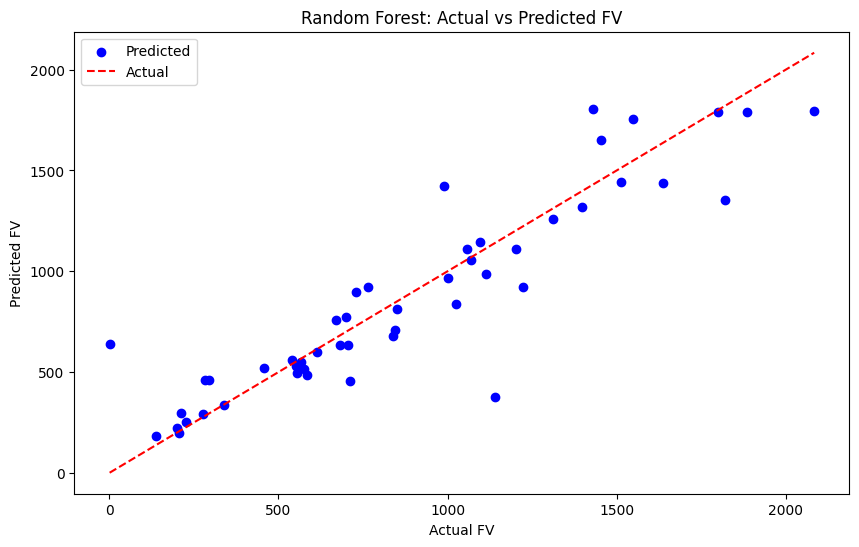

In [ ]:
#VISUALIZATION OF RANDOM FOREST: ACTUAL VS PREDICTED
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Actual')
plt.xlabel('Actual FV')
plt.ylabel('Predicted FV')
plt.title('Random Forest: Actual vs Predicted FV')
plt.legend()
plt.show()

## Other models

We are going to see if other models can do best compared to Random Forest. We will evaluate them and do the plot of the best one.

In [ ]:
#EVALUATION OF OTHER MODELS

with open('dataDefn.json') as json_file:
    json_data = json.load(json_file)

data = []
for entry in json_data:
    if 'fv' in entry and entry['fv']:
        data.append({
            'fecha': pd.to_datetime(entry['fecha']).toordinal(),
            'tmed': entry['tmed'],
            'prec': float(entry['prec']),
            'tmin': entry['tmin'],
            'tmax': entry['tmax'],
            'sol': float(entry['sol']) if isinstance(entry['sol'], str) else entry['sol'],
            'fv': float(entry['fv'].replace(",", ""))
        })

df = pd.DataFrame(data)

X = df[['fecha', 'tmed', 'prec', 'tmin', 'tmax', 'sol']] #features
y = df['fv'] #target

# split of the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# evaluation of the results
def evaluate_model(model, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f"{model_name} RMSE: {rmse}")

# Gradient Boosting Regressor
gb_regressor = GradientBoostingRegressor(n_estimators=100, random_state=42)
evaluate_model(gb_regressor, "Gradient Boosting")

# XGBoost Regressor
xgb_regressor = xgb.XGBRegressor(n_estimators=100, random_state=42)
evaluate_model(xgb_regressor, "XGBoost")

# Support Vector Regressor
svr_regressor = SVR(kernel='rbf')
evaluate_model(svr_regressor, "SVR")

# MLP Regressor
mlp_regressor = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=1000, random_state=42)
evaluate_model(mlp_regressor, "MLP Regressor")



Gradient Boosting RMSE: 36126.121273639634
XGBoost RMSE: 39834.058899937154
SVR RMSE: 57324.558989351775
MLP Regressor RMSE: 55801.69839430684


As we can see in the previous results, the model that works best (has a lower RMSE) is Gradient Boosting. Therefore we are going to evaluate it and do the visualization.

In [ ]:
# evaluation of Gradient Boosting Regressor
gb_regressor = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_regressor.fit(X_train, y_train)
y_pred_gb = gb_regressor.predict(X_test)
mse_gb = mean_squared_error(y_test, y_pred_gb)


print("Gradient Boosting Mean Squared Error:", mse_gb)

#results only for Gradient Boosting
print("\nDate\t\tActual FV\tPredicted FV")
for actual, predicted in zip(y_test, y_pred_gb):
    print(f"{actual:.2f}\t\t{predicted:.2f}")

Gradient Boosting Mean Squared Error: 1305096638.2777183

Date		Actual FV	Predicted FV
12233.00		109710.75
139808.00		133052.61
188473.00		172227.19
76395.00		97499.35
208394.00		175626.55
2016.00		20844.26
14548.00		125765.61
99101.00		135397.45
131298.00		117317.35
55484.00		48141.38
29456.00		59997.10
106.00		49493.88
179961.00		124142.15
163693.00		120587.60
68335.00		50006.21
70061.00		60952.30
2772.00		34617.11
109459.00		111167.59
84436.00		71456.02
61438.00		65934.55
102503.00		83048.98
66946.00		85859.50
55138.00		48141.38
11125.00		57828.57
20543.00		21820.21
21201.00		30759.12
105785.00		110151.70
73043.00		57454.33
58348.00		64531.31
85027.00		51205.65
45839.00		52979.96
154968.00		176850.08
12025.00		114090.01
70697.00		69233.93
71135.00		41759.21
13889.00		21455.94
57487.00		48141.38
151376.00		135884.02
3387.00		28846.57
182152.00		155482.47
2829.00		17921.48
56603.00		55776.49
53989.00		59179.07
106929.00		112915.59
113917.00		21162.96
83897.00		56254.42
142972.00		1609

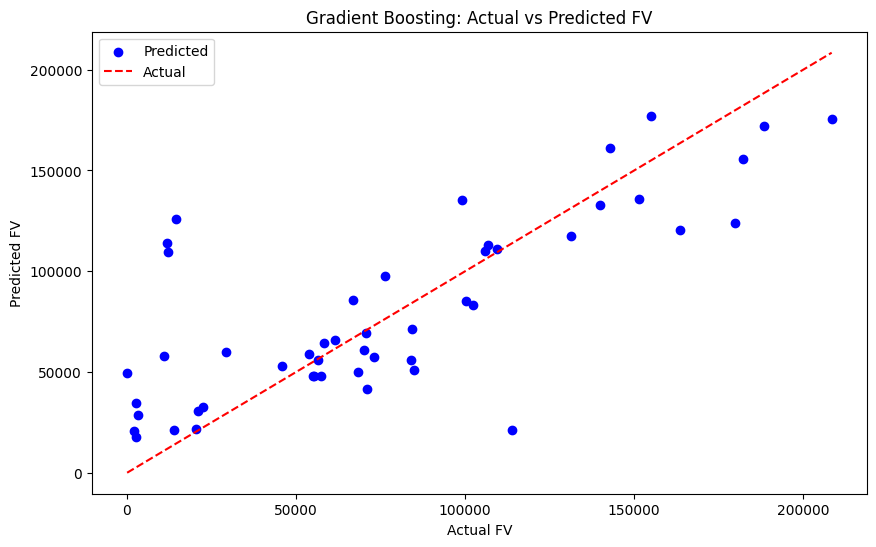

In [ ]:
#VISUALIZATION OF GRADIENT BOOSTING ACTUAL VS PREDICTED

# plot actual vs predicted FV
plt.figure(figsize=(10, 6))
plt.scatter(y_test, gb_regressor.predict(X_test), color='blue', label='Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Actual')
plt.xlabel('Actual FV')
plt.ylabel('Predicted FV')
plt.title('Gradient Boosting: Actual vs Predicted FV')
plt.legend()
plt.show()

# Model Predictions without SOL variable

To enable comparisons, we decided to attempt PV production predictions without using the Sol (insolation) variable. Previously, we used an MLP to predict missing Sol values to complete our dataset. However, this process might introduce errors and noise, potentially impacting the accuracy of our predictions due to accumulated errors. Therefore, we will now try making predictions without relying on the Sol variable to observe the results.

In [ ]:
#RANDOM FOREST REGRESSOR WITHOUT SOL VARIABLE

with open('dataDefn.json') as json_file:
    json_data = json.load(json_file)

data = []
for entry in json_data:
    if 'fv' in entry and entry['fv']:
        entry_data = {
            'fecha': entry['fecha'],
            'tmed': entry['tmed'],
            'prec': float(entry['prec']) if 'prec' in entry else 0.0,
            'tmin': entry['tmin'],
            'tmax': entry['tmax'],
            'fv': float(entry['fv'].replace(",", "")) if isinstance(entry['fv'], str) else float(entry['fv'])
        }
        data.append(entry_data)

df = pd.DataFrame(data)

# dates to ordinal
df['fecha'] = pd.to_datetime(df['fecha']).map(pd.Timestamp.toordinal)

# we separate features and target variable (excluding 'sol')
features = df[['fecha', 'tmed', 'prec', 'tmin', 'tmax']]
target = df['fv']

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('regressor', RandomForestRegressor(random_state=42))
])

#hyperparameter grid for Random Forest
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

# Grid Search (to find the best hyperparameters)
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# best model
best_model = grid_search.best_estimator_

# predictions on the test set
y_pred = best_model.predict(X_test)

# evaluation of the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)


print("Date\t\tActual FV\tPredicted FV")
for i, (date, actual, predicted) in enumerate(zip(features['fecha'], target, best_model.predict(features))):
    actual_date = pd.Timestamp.fromordinal(int(date)).strftime('%Y-%m-%d')
    print(f"{actual_date}\t{actual:.2f}\t\t{predicted:.2f}")

Mean Squared Error: 1317165134.2266946
Root Mean Squared Error: 36292.76972382646
Date		Actual FV	Predicted FV
2023-09-01	129515.00		119246.95
2023-09-02	61325.00		78062.44
2023-09-03	88232.00		101542.67
2023-09-04	120812.00		110904.48
2023-09-05	124962.00		115533.21
2023-09-06	129699.00		121120.12
2023-09-07	139808.00		127218.51
2023-09-08	136409.00		128542.63
2023-09-09	136563.00		130158.75
2023-09-10	131298.00		124460.71
2023-09-11	105785.00		96720.42
2023-09-12	98074.00		95852.81
2023-09-13	11098.00		46953.43
2023-09-14	111634.00		102775.58
2023-09-15	31869.00		61004.95
2023-09-16	109459.00		105554.40
2023-09-17	106929.00		108988.19
2023-09-18	121078.00		111472.69
2023-09-19	71135.00		63580.62
2023-09-20	66946.00		95407.17
2023-09-21	100819.00		102078.37
2023-09-22	129576.00		115898.68
2023-09-23	115702.00		112912.26
2023-09-24	123588.00		118749.47
2023-09-25	12233.00		110432.53
2023-09-26	12025.00		110836.43
2023-09-27	116688.00		109222.57
2023-09-28	113024.00		106957.85
2023-09-2

# PREDICTIONS


What needs to be inserted here is the .xml file with the link: https://www.aemet.es/xml/municipios/localidad_08266.xml

In [ ]:
#PREPROCESSING OF THE .XML FILE WITH THE METEO PREDICTIONS

import xml.etree.ElementTree as ET
import json
import requests
import pandas as pd

url_aemet_pred = "https://www.aemet.es/xml/municipios/localidad_08266.xml"

response = requests.get(url_aemet_pred)
response.encoding = "latin-1"


#option for directly download file
"""
with open("localidad_08266.xml", encoding = "latin-1") as meteo_preds:
    tree = ET.parse(meteo_preds)
    root = tree.getroot()
"""

root = ET.fromstring(response.content)
json_data = []

for day in root.find("prediccion").findall("dia"):
  fecha = day.attrib["fecha"]
  tmax = float(day.find("temperatura/maxima").text)
  tmin = float(day.find('temperatura/minima').text)
  tmed = (tmax + tmin) / 2

  prec = 0.0
  for prob_prec in day.findall("prob_precipitacion"):
    if prob_prec.attrib.get("periodo") == "00-24":
      prec = float(prob_prec.text) if prob_prec.text else 0.0
      break
  json_data.append({
      "fecha": fecha,
      "tmed": tmed,
      "prec": prec,
      "tmin": tmin,
      "horatmin": "",
      "tmax": tmax,
      "sol": "",
      "hrMedia": "",
      "fv": ""
    })


json_output = json.dumps(json_data, indent=4)
with open('pred_meteoo.json', 'w') as json_file:
    json_file.write(json_output)

print("JSON file has been created successfully.")



JSON file has been created successfully.


In [ ]:
with open('pred_meteoo.json') as json_file:
    json_data = json.load(json_file)

# extract and clean data
data = []
for entry in json_data:
        entry_data = {
            'fecha': entry['fecha'],
            'tmed': entry['tmed'],
            'prec': float(entry['prec']) if 'prec' in entry else 0.0,
            'tmin': entry['tmin'],
            'tmax': entry['tmax'],
        }
        data.append(entry_data)

new_pred = pd.DataFrame(data)


In [ ]:
new_pred

,fecha,tmed,prec,tmin,tmax
0,2024-05-26,19.5,0.0,13.0,26.0
1,2024-05-27,20.5,65.0,16.0,25.0
2,2024-05-28,20.5,0.0,15.0,26.0
3,2024-05-29,21.5,0.0,15.0,28.0
4,2024-05-30,20.5,0.0,15.0,26.0
5,2024-05-31,18.5,0.0,14.0,23.0
6,2024-06-01,17.0,0.0,13.0,21.0


In [ ]:
with open('dataDefn.json') as json_file:
    json_data = json.load(json_file)


data = []
for entry in json_data:
    if 'fv' in entry and entry['fv']:
        entry_data = {
            'fecha': entry['fecha'],
            'tmed': entry['tmed'],
            'prec': float(entry['prec']) if 'prec' in entry else 0.0,
            'tmin': entry['tmin'],
            'tmax': entry['tmax'],
            'sol': float(entry['sol'].replace(",", ".")) if isinstance(entry['sol'], str) else float(entry['sol']),
            'fv': float(entry['fv'].replace(",", ".")) if isinstance(entry['fv'], str) else float(entry['fv'])
        }
        data.append(entry_data)

df = pd.DataFrame(data)
df['fecha'] = pd.to_datetime(df['fecha']).map(pd.Timestamp.toordinal)

# features and target variable
features = df[['fecha', 'tmed', 'prec', 'tmin', 'tmax', 'sol']]
target = df['fv']

# split of the data (training and testing sets)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('regressor', RandomForestRegressor(random_state=42))
])

#hyperparameter grid for Random Forest (to find the best hyperparameters)
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

# Grid Search to find the best hyperparameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# we save the best model
best_model = grid_search.best_estimator_
joblib.dump(best_model, 'best_model.pkl')



        fecha  predicted_fv
0  2024-05-26     796.88405
1  2024-05-27     746.93070
2  2024-05-28     800.28125
3  2024-05-29     800.28125
4  2024-05-30     800.28125
5  2024-05-31     800.28125
6  2024-06-01     797.22550


**The function below is the one that needs to be executed to make the predictions. The model has already been trained and saved in a .plk file, which is also in the synthesis project folder.**

In [ ]:
#ABOVE IS THE WHOLE PROCESS, WITH THE TRAINING OF THE MODEL. IN ORDER TO JUST DO THE PREDICTIONS, JUST EXCUTE THE FOLLOWING CELL, THAT USE THE PRETRAINED MODEL STORED IN .pkl

import xml.etree.ElementTree as ET
import json
import requests
import pandas as pd

url_aemet_pred = "https://www.aemet.es/xml/municipios/localidad_08266.xml"

response = requests.get(url_aemet_pred)
response.encoding = "latin-1"



root = ET.fromstring(response.content)
json_data = []

for day in root.find("prediccion").findall("dia"):
  fecha = day.attrib["fecha"]
  tmax = float(day.find("temperatura/maxima").text)
  tmin = float(day.find('temperatura/minima').text)
  tmed = (tmax + tmin) / 2

  prec = 0.0
  for prob_prec in day.findall("prob_precipitacion"):
    if prob_prec.attrib.get("periodo") == "00-24":
      prec = float(prob_prec.text) if prob_prec.text else 0.0
      break
  json_data.append({
      "fecha": fecha,
      "tmed": tmed,
      "prec": prec,
      "tmin": tmin,
      "horatmin": "",
      "tmax": tmax,
      "sol": "",
      "hrMedia": "",
      "fv": ""
    })

json_output = json.dumps(json_data, indent=4)
with open('pred_meteoo.json', 'w') as json_file:
    json_file.write(json_output)
print("JSON file has been created successfully.")

with open('pred_meteoo.json') as json_file:
    json_data = json.load(json_file)


data = []
for entry in json_data:
        entry_data = {
            'fecha': entry['fecha'],
            'tmed': entry['tmed'],
            'prec': float(entry['prec']) if 'prec' in entry else 0.0,
            'tmin': entry['tmin'],
            'tmax': entry['tmax'],
        }
        data.append(entry_data)

new_pred = pd.DataFrame(data)

# we define a function to preprocess new input data
def preprocess_input(data):
    for entry in data:
        entry['fecha'] = pd.to_datetime(entry['fecha']).toordinal()
        entry['prec'] = float(entry['prec']) if 'prec' in entry else 0.0
        # if 'sol' is not provided in new data, set it to 0
        entry['sol'] = 0.0
    return pd.DataFrame(data)

# function to make predictions given new input
def predict_fv(input_data):
    model = joblib.load('best_model.pkl')
    # we call the function in order to preprocess the input data
    preprocessed_data = preprocess_input(input_data)

    #relevant features and predictions are being extracted
    features = preprocessed_data[['fecha', 'tmed', 'prec', 'tmin', 'tmax', 'sol']]
    predictions = model.predict(features)

    # we convert dates back to readable format
    preprocessed_data['fecha'] = preprocessed_data['fecha'].map(lambda x: pd.Timestamp.fromordinal(x).strftime('%Y-%m-%d'))

    # we add predictions to the DataFrame
    preprocessed_data['predicted_fv'] = predictions

    return preprocessed_data[['fecha', 'predicted_fv']]


with open('pred_meteoo.json') as json_file:
    json_data = json.load(json_file)

# clean new input data
data = []
for entry in json_data:
    entry_data = {
        'fecha': entry['fecha'],
        'tmed': entry['tmed'],
        'prec': float(entry['prec']) if 'prec' in entry else 0.0,
        'tmin': entry['tmin'],
        'tmax': entry['tmax']
    }
    data.append(entry_data)

# predictions
predictions = predict_fv(data)
print(predictions)


JSON file has been created successfully.
        fecha  predicted_fv
0  2024-05-26     796.88405
1  2024-05-27     746.93070
2  2024-05-28     800.28125
3  2024-05-29     800.28125
4  2024-05-30     800.28125
5  2024-05-31     800.28125
6  2024-06-01     797.22550


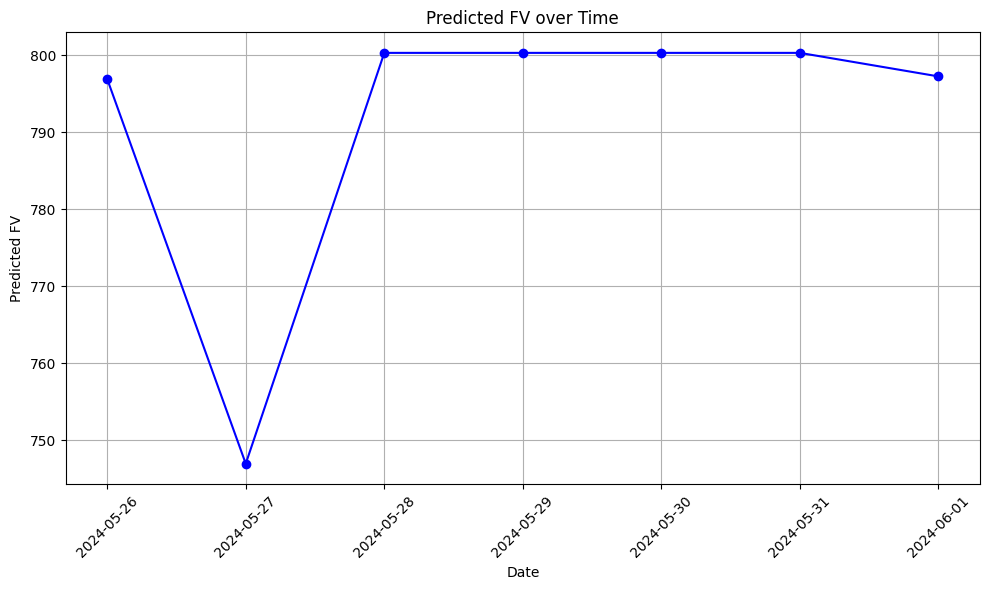

In [ ]:
#PLOT THE DATA

df = pd.DataFrame(predictions)
df['fecha'] = pd.to_datetime(df['fecha'])

# plotting
plt.figure(figsize=(10, 6))
plt.plot(df['fecha'], df['predicted_fv'], marker='o', linestyle='-', color='b')
plt.title('Predicted FV over Time')
plt.xlabel('Date')
plt.ylabel('Predicted FV')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()


plt.show()

In [ ]:
#MODEL EVALUATION

import json
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import joblib

# load the saved model
best_model = joblib.load('best_model.pkl')

# load the data
with open('dataDefn.json') as json_file:
    json_data = json.load(json_file)

# extract and clean data
data = []
for entry in json_data:
    if 'fv' in entry and entry['fv']:
        entry_data = {
            'fecha': entry['fecha'],
            'tmed': entry['tmed'],
            'prec': float(entry['prec']) if 'prec' in entry else 0.0,
            'tmin': entry['tmin'],
            'tmax': entry['tmax'],
            'sol': float(entry['sol'].replace(",", ".")) if isinstance(entry['sol'], str) else float(entry['sol']),
            'fv': float(entry['fv'].replace(",", ".")) if isinstance(entry['fv'], str) else float(entry['fv'])
        }
        data.append(entry_data)

df = pd.DataFrame(data)


df['fecha'] = pd.to_datetime(df['fecha']).map(pd.Timestamp.toordinal)
features = df[['fecha', 'tmed', 'prec', 'tmin', 'tmax', 'sol']]
target = df['fv']

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

#predictions on test set
y_pred = best_model.predict(X_test)

# performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
explained_variance = explained_variance_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

#information and metrics
print("Number of samples in training set:", len(X_train))
print("Number of samples in test set:", len(X_test))
print("Number of features:", X_train.shape[1])
print("\nPerformance Metrics:")
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)
print("Explained Variance Score:", explained_variance)



# in order to see some results we print actual vs predicted values for the first few samples in the test set
print("\nActual vs Predicted 'fv' values (first 10 samples):")
print("Date\t\tActual FV\tPredicted FV")
for i, (date, actual, predicted) in enumerate(zip(X_test['fecha'].head(10), y_test.head(10), y_pred[:10])):
    actual_date = pd.Timestamp.fromordinal(int(date)).strftime('%Y-%m-%d')
    print(f"{actual_date}\t{actual:.2f}\t\t{predicted:.2f}")


Number of samples in training set: 192
Number of samples in test set: 49
Number of features: 6

Performance Metrics:
Mean Squared Error (MSE): 44800.96851883689
Root Mean Squared Error (RMSE): 211.6623927835006
Mean Absolute Error (MAE): 139.10428180783393
R-squared (R2): 0.8277262084437567
Explained Variance Score: 0.8285508059792759

Actual vs Predicted 'fv' values (first 10 samples):
Date		Actual FV	Predicted FV
2023-09-25	1223.30		922.80
2023-09-07	1398.08		1318.45
2024-04-10	1884.73		1792.15
2024-03-27	763.95		921.65
2024-04-24	2083.94		1796.96
2024-02-21	201.60		223.84
2024-03-16	1454.80		1653.44
2024-04-08	991.01		1422.15
2023-09-10	1312.98		1260.00
2023-12-23	554.84		494.71


# EVALUATION AND CONCLUSIONS OF OUR MODEL

**Mean Squared Error (MSE) and Root Mean Squared Error (RMSE):**

The MSE and RMSE indicate the average squared difference between the actual and predicted values. An RMSE of 211.66 suggests that, on average, the model's predictions deviate from the actual values by around 211.66 units.

**Mean Absolute Error (MAE):**

The MAE measures the average magnitude of errors in the predictions, with an average error of 139.10 units. This provides a more interpretable error measure compared to RMSE, as it is not squared.

**R-squared (R²):**

An R² of 0.8277 implies that approximately 82.77% of the variance in the target variable (fv) is explained by the model. This indicates a strong model performance, as a value closer to 1 suggests a better fit.

**Explained Variance Score:**

The score of 0.8286 is very close to the R² value, indicating consistent performance. It shows the proportion of variance explained by the model, reinforcing the R² interpretation.


**Actual vs Predicted "fv" Values:**

The comparison of actual and predicted values for the first 10 samples shows that the model performs well overall but has notable deviations in some cases. For example, the actual FV on 2024-04-10 is 1884.73, while the predicted value is 1792.15. Such discrepancies highlight areas for potential improvement.

**CONCLUSION:**

The model shows strong predictive performance with an R² of 0.8277, indicating that it explains a large proportion of the variance in the target variable. The high importance of the 'fecha' and 'sol' features suggests that these are critical to accurate predictions. However, the presence of some significant deviations between actual and predicted values points to areas where the model could be further refined.
